In [1]:
%load_ext line_profiler
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time
import pickle

from collections import Counter, defaultdict, OrderedDict, namedtuple
import random
import copy
import bisect
import heapq

import multiprocessing as mp
from multiprocessing import Pool

import warnings
warnings.filterwarnings('error')

In [312]:
records=pd.read_csv('data/ydata-fp-td-clicks-v2_0.20111016', 
                    sep=' ',
                    names=['timestamp','id','clicked'],
                    usecols=[0,1,2],)

In [313]:
records.head()

,timestamp,id,clicked
0,1318722892,id-613505,0
1,1318722892,id-613546,0
2,1318722892,id-605423,0
3,1318722892,id-600025,0
4,1318722892,id-611479,0


In [314]:
records.tail()

,timestamp,id,clicked
1292233,1318809293,id-611679,0
1292234,1318809293,id-610503,0
1292235,1318809293,id-614718,0
1292236,1318809293,id-611679,0
1292237,1318809293,id-614050,0


In [24]:
with open('save/lifespans','rb') as f:
    lifespans = pickle.load(f)

24 1317830699 1317783600 13.083055555555555
20 1318789799 1318742700 13.083055555555555


51

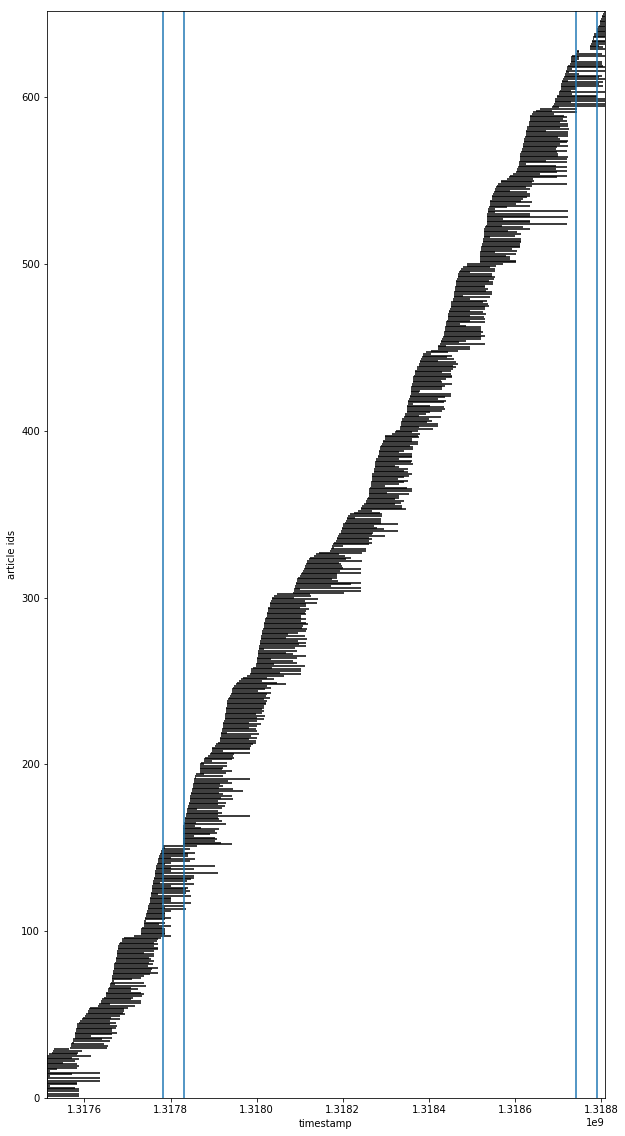

In [307]:
plt.figure(figsize=(10,20))
y=0
for start,stop in lifespans.values():
    plt.hlines(y, xmin=start, xmax=stop)
    #plt.scatter(np.arange(start,stop,1000),[y for j in range(start,stop,1000)], marker='.')
    y+=1
plt.xlabel('timestamp')
plt.ylabel('article ids')
plt.xlim(1317513291, 1318809293)
plt.ylim(0,652)

l=[] # min heap with items like: (stop, start, arm)
global_max=0
for i in lifespans.items():
    arm=i[0]
    start,stop=i[1]
    while l and l[0][0]<start:
        heapq.heappop(l)
        if len(l)>=20:
            min_stop=l[0][0]
            max_start=max(l, key=lambda i:i[1])[1]
            if min_stop-max_start>=3600*12:
                plt.axvline(min_stop)
                plt.axvline(max_start)
                pool=[i[2] for i in l]
                print(len(l), min_stop, max_start, (min_stop-max_start)/3600)
    heapq.heappush(l,(stop,start,arm)) # min stop (earliest expiring)
    
    global_max=max(global_max, len(l))
global_max

In [316]:
start=records[records.timestamp==1318742700].index[0]
stop=records[records.timestamp==1318789799].index[-1]
slice=records.iloc[start:stop+1]
slice

,timestamp,id,clicked
369927,1318742700,id-611932,0
369928,1318742700,id-611585,0
369929,1318742700,id-611932,0
369930,1318742700,id-606207,0
369931,1318742700,id-613546,0
369932,1318742701,id-613856,0
369933,1318742701,id-614010,0
369934,1318742701,id-613546,0
369935,1318742701,id-611585,0
369936,1318742701,id-614016,0


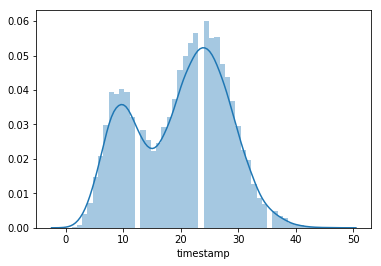

In [317]:
sns.distplot(slice.timestamp.value_counts())

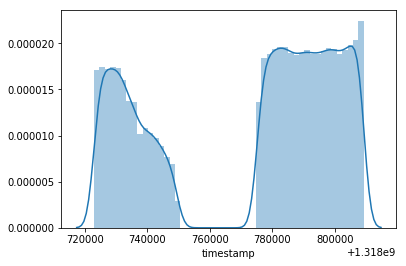

In [319]:
sns.distplot(records.timestamp)

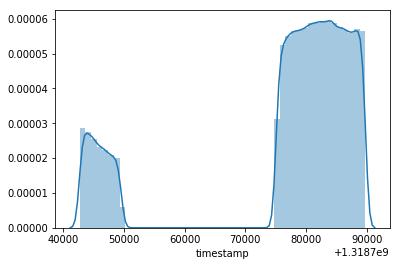

In [318]:
sns.distplot(slice.timestamp)

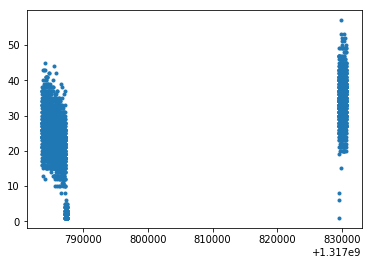

In [289]:
plt.scatter(slice.timestamp.value_counts().index, slice.timestamp.value_counts().values, marker='.')

In [129]:
slice.timestamp.value_counts().describe()

count    5038.000000
mean       25.570266
std         8.608354
min         1.000000
25%        21.000000
50%        26.000000
75%        31.000000
max        57.000000
Name: timestamp, dtype: float64

In [164]:
class Arm:
    def __init__(self):
        self.T = 0
        self.rewards = 0
        self.X = -1
    def __repr__(self):
        return '{:.4f} {}/{}'.format(self.X, self.rewards, self.T)
    

In [262]:
class Epsilon_z_greedy:
    def __init__(self, records=slice, pool=pool, G=slice.timestamp.value_counts()):
        self.records = records.itertuples() # optimal speed, sub-optimal space
        self.rewards = 0
        self.pool = {}
        self.G = G
        for k in pool:
            self.pool[k] = Arm()
        self.best = None
        self.prev_time = None
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        if not self.best:
            self.best = record.id
        else:
            self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
                
    def initialize(self, m=24):
        i=0
        while i<m:
            try:
                record = next(self.records) # raise StopIteration
            except StopIteration as si:
                print(si, record)
                return
            if record.id not in self.pool:
                continue
            if not self.pool[record.id].T: # not played
                self.update(record)
                i+=1
    
    def play(self, n, m=24, z=31, threshold=.3):
        k=250 # k>4/(best.X-2ndBest.X)
        self.t_ = 1
        for t in range(n):
            while True: # keep feeding event stream until event matches desired action
                try:
                    record = next(self.records) # raise StopIteration
                except StopIteration as si:
                    print(si, record)
                    return
                if record.id not in self.pool:
                    continue
                    
                if record.timestamp == self.prev_time: # still in the last time bin
                    pick = self.prev_pick # lock recommendation
                else: # entering a new time bin
                    epsilon = min(1, k*m/self.t_)
                    if self.G[record.timestamp]<z and random.random()<epsilon:
                        pick = random.choice(list(self.pool))
                    else:
                        pick = self.best

                if pick == record.id:
                    self.update(record)
                    self.prev_pick = pick
                    self.prev_time = record.timestamp
                    if self.G[record.timestamp]<z:
                        self.t_ += 1
                    break

In [263]:
ezg = Epsilon_z_greedy()
ezg.initialize()
ezg.play(2000)
ezg.rewards

96

In [223]:
ezg2 = Epsilon_z_greedy()
ezg2.initialize()
ezg2.play(2000, z=100)
ezg2.rewards

85

In [228]:
4/(0.0746-0.058)

240.9638554216868

In [221]:
ezg.pool

{'id-573268': 0.0444 2/45,
 'id-571050': 0.0000 0/35,
 'id-571679': 0.0000 0/50,
 'id-568437': 0.0500 2/40,
 'id-571956': 0.0000 0/50,
 'id-569417': 0.0000 0/58,
 'id-572582': 0.0535 16/299,
 'id-571705': 0.0580 4/69,
 'id-573053': 0.0000 0/51,
 'id-569065': 0.0515 12/233,
 'id-572112': 0.0746 35/469,
 'id-572263': 0.0196 1/51,
 'id-571469': 0.0227 1/44,
 'id-571880': 0.0000 0/43,
 'id-573391': 0.0238 1/42,
 'id-570846': 0.0217 1/46,
 'id-573039': 0.0000 0/50,
 'id-573241': 0.0476 2/42,
 'id-569364': 0.0000 0/45,
 'id-569088': 0.0222 1/45,
 'id-572219': 0.0556 6/108,
 'id-564492': 0.0000 0/32,
 'id-573243': 0.0323 1/31,
 'id-572825': 0.0435 2/46}

In [231]:
l1=[]
l2=[]
for i in range(100):
    ezg = Epsilon_z_greedy()
    ezg.initialize()
    ezg.play(2000)
    l1.append(ezg.rewards)

    ezg2 = Epsilon_z_greedy()
    ezg2.initialize()
    ezg2.play(2000, z=100)
    l2.append(ezg2.rewards)
    
    print(i, end='\r', flush=True)

Text(0.5, 1.0, 'reward distributions')

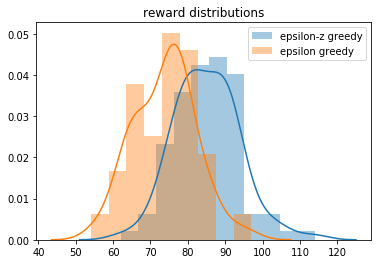

In [232]:
sns.distplot(l1, label='epsilon-z greedy')
sns.distplot(l2, label='epsilon greedy')
plt.legend()
plt.title('reward distributions')

In [264]:
l3=[]
for i in range(100):
    ezg3 = Epsilon_z_greedy()
    ezg3.initialize()
    ezg3.play(2000)
    l3.append(ezg3.rewards)

Text(0.5, 1.0, 'reward distributions')

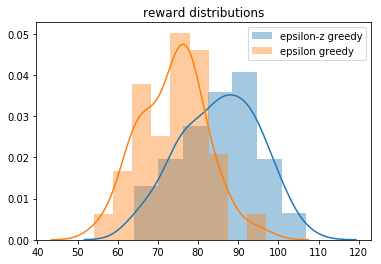

In [265]:
sns.distplot(l3, label='epsilon-z greedy')
sns.distplot(l2, label='epsilon greedy')
plt.legend()
plt.title('reward distributions')